In [1]:
from swap_TN_direct import *

from sequence.components.polarization_fock.quantum_manager import _build_amp_damping_kraus_operators
import numpy as np
from matplotlib import pyplot as plt
from quimb.tensor.tensor_arbgeom import tensor_network_apply_op_vec

import time
import json
import itertools

import warnings
warnings.simplefilter('error')

/home/asingal/home/.venv/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/asingal/home/.venv/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:33: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


In [2]:
a = np.array([5,8,1,0])
np.argsort(a)

array([3, 2, 0, 1])

Common parameters and functions

In [8]:
class quantum_channel:
    def __init__(self, N, num_modes, formalism, kraus_ops_tuple = None, unitary_MPOs = None):
        self.N = N
        self.num_modes = num_modes
        self.formalism = formalism
        if self.formalism == 'kraus':
            # Calculate the MPOs of the Kraus operators
            self.kraus_MPOs = quantum_channel.find_quantum_channels_MPOs(kraus_ops_tuple, N, num_modes)
        elif self.formalism == 'closed':
            self.unitary_MPOs = unitary_MPOs

    def get_MPOs(self):
        if self.formalism == 'closed':
            return self.unitary_MPOs
        elif self.formalism == 'kraus':
            return self.kraus_MPOs

    @staticmethod
    def find_quantum_channels_MPOs(ops_tuple, N, num_modes):
        (sites, ops) = ops_tuple
        quantum_channels = quantum_channel.calc_mpos(ops, N, sites, num_modes)
        return quantum_channels

    # Just a function which calcualte the MPOs of the Kraus ops
    @staticmethod
    def calc_mpos(ops, N, sites, num_modes):
        MPOs = []
        for op in ops:
            MPO = mpo.from_dense(op.todense(), dims = N, sites = sites, L=num_modes, tags="op")
            MPOs.append(MPO)
        return MPOs


class trajectree_node:
    def __init__(self, probs, trajectories, trajectory_indices):
        self.probs = probs
        self.trajectories = trajectories
        self.trajectory_indices = trajectory_indices

class trajectory_evaluator():
    def __init__(self, quantum_channels, cache_size = 2):
        self.quantum_channels = quantum_channels
        self.kraus_channels = []
        for quantum_channel in self.quantum_channels:
            if quantum_channel.formalism == 'kraus':
                self.kraus_channels.append(quantum_channel)

        self.trajectree = [{} for i in range(len(self.kraus_channels)+1)] # +1 because you also cache the end of the simulation so you prevent doing the final unitary operations multiple times. 
        self.traversed_nodes = ()
        self.cache_size = cache_size

        # for debugging only:
        self.cache_hit = 0
        self.cache_miss = 0
        self.cache_partial_hit = 0


    def apply_kraus(self, psi, kraus_MPOs, error_tolerance, normalize = True):
        trajectory_probs = np.array([])
        trajectories = np.array([])
        # print("inintial psi amplitude:", np.real(psi.H @ psi))
        # print("len of kraus ops:", len(kraus_MPOs))
        for kraus_MPO in kraus_MPOs:

            trajectory = tensor_network_apply_op_vec(kraus_MPO, psi, compress=True, contract = True, cutoff = error_tolerance)
            # print("Applying the Kraus operators:")
            # read_quantum_state(trajectory, 4)
            trajectory_prob = np.real(trajectory.H @ trajectory)
            
            # print("probability", trajectory_prob)
            if trajectory_prob < 1e-25: # Using 1e-25 arbitrarily. Trajectories with probability less than this are pruned.  
                continue

            if normalize:
                trajectory.normalize()
            trajectory_probs = np.append(trajectory_probs, trajectory_prob)
            trajectories = np.append(trajectories, trajectory)

        # print("New node probs:", trajectory_probs)

        return trajectories, trajectory_probs


    def cache_trajectree_node(self, trajectory_probs, trajectories):
        sorted_indices = np.argsort(trajectory_probs)
        print("sorted_indices", sorted_indices)

        cached_trajectory_indices = sorted_indices[-self.cache_size:]
        print("cached_trajectory_indices", cached_trajectory_indices)
        # print("cached_trajectory_indices", cached_trajectory_indices)
        cached_trajectories = np.array(trajectories)[cached_trajectory_indices]

        new_node = trajectree_node(trajectory_probs, cached_trajectories, cached_trajectory_indices)
        self.trajectree[len(self.traversed_nodes)][self.traversed_nodes] = new_node

        self.last_cached_node = new_node

        return cached_trajectory_indices


    def discover_trajectree_node(self, psi, kraus_MPOs, error_tolerance, normalize = True, selected_trajectory_index = None):
        
        trajectories, trajectory_probs = self.apply_kraus(psi, kraus_MPOs, error_tolerance, normalize)
        print("trajectory_probs", trajectory_probs)

        cached_trajectory_indices = self.cache_trajectree_node(trajectory_probs, trajectories)

        if selected_trajectory_index == None:
            selected_trajectory_index = np.random.choice(a = len(trajectory_probs), p = trajectory_probs/sum(trajectory_probs))
        print(" caching kraus op at idx", selected_trajectory_index, "after level", len(self.traversed_nodes), "at node", self.traversed_nodes, end = ' ')
        
        self.traversed_nodes = self.traversed_nodes + (selected_trajectory_index,)

        # self.cache_unitary = (not selected_trajectory_index in cached_trajectory_indices) and self.cache_unitary


        return trajectories[selected_trajectory_index]


    def query_trajectree(self, psi, kraus_MPOs, error_tolerance, cache = True, selected_trajectory_index = None, normalize = True):
        self.skip_unitary = False
        self.cache_unitary = False

        if cache == False:
            psi = tensor_network_apply_op_vec(self.kraus_channels[len(self.traversed_nodes)].get_MPOs()[selected_trajectory_index], psi, compress=True, contract = True, cutoff = error_tolerance)
            self.traversed_nodes = self.traversed_nodes + (selected_trajectory_index,)
            return psi

        print("Entering query_trajectree: selected index:", selected_trajectory_index)
        # print("entering query_trajectree, self.traversed_nodes:", self.traversed_nodes)
        if self.traversed_nodes in self.trajectree[len(self.traversed_nodes)]: # Check if the dictionary at level where the traversal is now, i.e., len(self.traversed_nodes)
                                                                               # has the path that the present traversal has taken. 
            node = self.trajectree[len(self.traversed_nodes)][self.traversed_nodes] # If found, index that node into the node object to call the probabilities and trajectories cached inside it.
            print("selected_trajectory_index:", selected_trajectory_index)
            if selected_trajectory_index == None:
                selected_trajectory_index = np.random.choice(a = len(node.probs), p = node.probs/sum(node.probs)) # The cached nodes have all the probabilities, but not all the trajectories cache. So, we can select
                                                                                                  # what trajecory our traversal takes and later see if the actual trajectory has been cached or needs to be retrieved. 
            self.cache_unitary = False # If the node has been found, we do not cache the unitary. The unitary is either already cached or we don't need to cache it at all.

            if selected_trajectory_index in node.trajectory_indices: # See if the selected trajectory's MPS has been cached or not. 
                print("cached kraus op found:", end = '')
                self.skip_unitary = True # If we're skipping the unitary entirely, it just does not matter whether we cache the unitary or not.
                self.cache_hit += 1
                psi = node.trajectories[np.where(node.trajectory_indices == selected_trajectory_index)[0][0]]
            else: 
                print("cached node found:", end = '')
                self.skip_unitary = False # If the trajectory has not been cached, we will have to apply the unitary to it.
                self.cache_partial_hit += 1
                psi = tensor_network_apply_op_vec(self.kraus_channels[len(self.traversed_nodes)].get_MPOs()[selected_trajectory_index], psi, compress=True, contract = True, cutoff = error_tolerance) # If not, simply calculate that trajectory. 
                                                                                                                                                                                             # You don't need to cache it since we have already cached what we had to.  
                if normalize:
                    psi.normalize()
            self.traversed_nodes = self.traversed_nodes + (selected_trajectory_index,)
            print(self.traversed_nodes)


        else: # If the node has not been discovered, we'll have to find all probabilities and cache the results. 
            self.skip_unitary = False
            self.cache_unitary = True
            self.cache_miss += 1
            print("no cached node:", end = '')
            psi = self.discover_trajectree_node(psi, kraus_MPOs, error_tolerance, normalize, selected_trajectory_index = selected_trajectory_index)

        return psi

    def apply_unitary_MPOs(self, psi, unitary_MPOs, error_tolerance):
        return tensor_network_apply_op_vec(unitary_MPOs, psi, compress=True, contract = True, cutoff = error_tolerance)


    def calculate_density_matrix(self, psi, error_tolerance):
        dm = 0
        trajectree_indices_list = [[]]
        for quantum_channel in self.quantum_channels:
            if quantum_channel.formalism == 'kraus':
                trajectree_indices_list = [[*i, j] for i in trajectree_indices_list for j in range(len(quantum_channel.get_MPOs()))]
        # print(trajectree_indices)
        for trajectree_indices in trajectree_indices_list:
            print("querying nodes:", trajectree_indices)
            # print("trajectory indices", trajectree_indices)
            print("trajectree_indices:", trajectree_indices)
            psi_new_dense = self.perform_simulation(psi, error_tolerance, cache = True, trajectree_indices = trajectree_indices, normalize = False).to_dense()
            dm += psi_new_dense @ psi_new_dense.conj().T
            # print("sparse array:", dm.nonzero())
        return dm

    def update_cached_node(self, unitary_MPOs, last_cached_node, error_tolerance):
        print("self.traversed_nodes:", self.traversed_nodes)
        for kraus_idx in range(len(last_cached_node.trajectories)):
            # traj_idx = np.where(last_cached_node.trajectory_indices == kraus_idx)[0][0]
            # print("caching unitary at idx", traj_idx, "after level", len(self.traversed_nodes), "at node", self.traversed_nodes)
            # print("traj_idx", traj_idx)
            last_cached_node.trajectories[kraus_idx] = self.apply_unitary_MPOs(last_cached_node.trajectories[kraus_idx], unitary_MPOs, error_tolerance)



    def perform_simulation(self, psi, error_tolerance, cache = True, trajectree_indices = None, normalize = True):
        self.traversed_nodes = ()
        self.skip_unitary = False
        self.cache_unitary = False
        for quantum_channel in self.quantum_channels:
            print()
            if quantum_channel.formalism == 'kraus':
                kraus_MPOs = quantum_channel.get_MPOs()
                if not trajectree_indices == None: # If the list of trajectoery indices is provided, we will use that to traverse the trajectree. The random number generators will not be used.
                    psi = self.query_trajectree(psi, kraus_MPOs, error_tolerance, cache, trajectree_indices.pop(0), normalize)
                else: # In this branch, you actually select the trajectory redomly and perform realistic simulations. 
                    psi = self.query_trajectree(psi, kraus_MPOs, error_tolerance, cache = cache, normalize = normalize)
                print("Applied kraus op:", self.traversed_nodes)

                # print("Applying kraus op:")
                # read_quantum_state(psi, N)
                print("traversed nodes after kraus op:", self.traversed_nodes)
                # if psi == self.trajectree[len(self.traversed_nodes)-1][self.traversed_nodes[:-1]].trajectories[self.traversed_nodes[-1]]:
                #     print("indexing is correct")
                # else:
                #     print("Incorrect indexing")

            elif quantum_channel.formalism == 'closed' and not self.skip_unitary:
                unitary_MPOs = quantum_channel.get_MPOs()
                                
                if not cache: # If we aren't aching the trajectories at all, simply apply the unitary MPOs to the state.
                    psi = self.apply_unitary_MPOs(psi, unitary_MPOs, error_tolerance)
                    continue

                last_cached_node = self.trajectree[len(self.traversed_nodes)-1][self.traversed_nodes[:-1]]
                
                if self.cache_unitary:
                    self.update_cached_node(unitary_MPOs, last_cached_node, error_tolerance)
                    # print("psi:")
                    # read_quantum_state(psi, N)
                    # print("self.trajectree[len(self.traversed_nodes)-1][self.traversed_nodes[:-1]].trajectories[self.traversed_nodes[-1]]")
                    # read_quantum_state(self.trajectree[len(self.traversed_nodes)-1][self.traversed_nodes[:-1]].trajectories[self.traversed_nodes[-1]], N)
                    # read_quantum_state(self.trajectree[1][(0,)].trajectories[1], N)
                    # if psi == self.trajectree[len(self.traversed_nodes)-1][self.traversed_nodes[:-1]].trajectories[self.traversed_nodes[-1]]:
                    #     print("indexing is correct")
                    # else:
                    #     print("Incorrect indexing")           
                traj_idx = np.where(last_cached_node.trajectory_indices == self.traversed_nodes[-1])    
                if traj_idx[0].size > 0:
                    psi = last_cached_node.trajectories[traj_idx[0][0]]
                else:
                    psi = self.apply_unitary_MPOs(psi, unitary_MPOs, error_tolerance)
            else:
                print("unitary skipped:", self.traversed_nodes)
            # read_quantum_state(psi, N = 2, num_states=4)
            # print("Traversed nodes:", self.traversed_nodes)
        return psi


In [4]:
def generate_swapping_circuit(N, num_modes, site_tags, det_eff, channel_loss, error_tolerance):
    quantum_channel_list = []

    # Amplitude damping due to fibers
    # damping_kraus_ops = _build_amp_damping_kraus_operators(loss_rate = channel_loss, N = N)
    damping_kraus_ops = _build_amp_damping_kraus_operators(loss_rate = channel_loss, N = N)
    quantum_channel_list.append(quantum_channel(N = N, num_modes = num_modes, formalism = "kraus", kraus_ops_tuple = ((2,3), damping_kraus_ops))) # The tuples in this list are defined as (sites, kraus_ops). The sites are the sites where the Kraus ops are applied.
    quantum_channel_list.append(quantum_channel(N = N, num_modes = num_modes, formalism = "kraus", kraus_ops_tuple = ((6,7), damping_kraus_ops))) # The tuples in this list are defined as (sites, kraus_ops). The sites are the sites where the Kraus ops are applied.

    # Quantum channel for the Bell state measurement
    BSM_MPOs = bell_state_measurement(None, N, site_tags, num_modes, det_eff, error_tolerance, pnr = False, return_MPOs = True, compress=True, contract=True)
    BSM_quantum_channels = [quantum_channel(N = N, num_modes = num_modes, formalism = "closed", unitary_MPOs = BSM_MPO) for BSM_MPO in BSM_MPOs]
    quantum_channel_list.extend(BSM_quantum_channels)

    return quantum_channel_list

def create_swapping_initial_state(num_modes, N, mean_photon_num, error_tolerance):
    # Create Vacuum state:
    vacuum = create_vacuum_state(num_modes=num_modes, N=N)

    # Entangled state from EPS
    psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
    # trying new ls here:
    # psi = new_ls(N, mean_photon_num, error_tolerance) 

    # Include emission from other lightsource
    psi = extend_MPS(psi)
    return psi

def perform_swapping_simulation(N, num_modes, mean_photon_num, det_eff, channel_loss, num_simulations, error_tolerance):

    psi = create_swapping_initial_state(num_modes, N, mean_photon_num, error_tolerance)

    # read_quantum_state(psi, N = N, num_states=4)

    quantum_channels = generate_swapping_circuit(N, num_modes, psi.site_tags, det_eff, channel_loss, error_tolerance)

    t_eval = trajectory_evaluator(quantum_channels)

    times = []
    expectations = []
    start = time.time()

    for i in range(num_simulations):        
        psi_iter = t_eval.perform_simulation(psi, error_tolerance)
        psi_iter.normalize()
        
        fidelity = np.abs(calc_fidelity_swapping(psi_iter, "psi_minus", N, error_tolerance))
        print("fidelity:", fidelity, "nodes:", t_eval.traversed_nodes)
        expectations.append(fidelity)

    # read_quantum_state(psi_iter, N = N, num_states=4)
    
    time_taken = time.time() - start
    print("completed set", "cache_hits:", t_eval.cache_hit, "cache_partial_hits:", t_eval.cache_partial_hit, "cache_misses:", t_eval.cache_miss,  "time taken:", time_taken)
    times.append(time_taken)

    return expectations, t_eval



In [5]:
# Set simulation params
trunc = 2
N = trunc+1
error_tolerance = 1e-15

mean_photon_num = 0.5 # (0.5)
det_eff = 1 # 0.9
channel_loss = 0.5


num_modes = 8
# Create vacuum state

idler_angles = np.linspace(0, np.pi, 1)
signal_angles = np.linspace(0, 4*np.pi, 30)

num_simulations = 1


cache_sizes = [2]

fidelities, t_eval = perform_swapping_simulation(N, num_modes, mean_photon_num, det_eff, channel_loss, num_simulations, error_tolerance)
print("average fidelity:", np.mean(fidelities))



Entering query_trajectree: selected index: None
no cached node:trajectory_probs [7.76444742e-01 9.35621485e-02 1.11541288e-02 9.35621485e-02
 1.12743060e-02 1.34408053e-03 1.11541288e-02 1.34408053e-03
 1.60236245e-04]
sorted_indices [8 7 5 6 2 4 3 1 0]
cached_trajectory_indices [1 0]
 caching kraus op at idx 3 after level 0 at node () Applied kraus op: (3,)
traversed nodes after kraus op: (3,)

Entering query_trajectree: selected index: None
no cached node:trajectory_probs [7.76444742e-01 9.35621485e-02 1.11541288e-02 9.35621485e-02
 1.12743060e-02 1.34408053e-03 1.11541288e-02 1.34408053e-03
 1.60236245e-04]
sorted_indices [8 7 5 6 2 4 3 1 0]
cached_trajectory_indices [1 0]
 caching kraus op at idx 0 after level 1 at node (3,) Applied kraus op: (3, 0)
traversed nodes after kraus op: (3, 0)

self.traversed_nodes: (3, 0)

self.traversed_nodes: (3, 0)

self.traversed_nodes: (3, 0)

self.traversed_nodes: (3, 0)

self.traversed_nodes: (3, 0)

self.traversed_nodes: (3, 0)
fidelity: 2.4185

In [6]:
# Find density matrix:
psi = create_swapping_initial_state(num_modes, N, mean_photon_num, error_tolerance)
# read_quantum_state(psi, N)
quantum_channels = generate_swapping_circuit(N, num_modes, psi.site_tags, det_eff, channel_loss, error_tolerance)
t_eval = trajectory_evaluator(quantum_channels)
dm = t_eval.calculate_density_matrix(psi, error_tolerance)

psi_minus = create_polarization_bell_state('psi_minus', N)


querying nodes: [0, 0]
trajectree_indices: [0, 0]

Entering query_trajectree: selected index: 0
no cached node:trajectory_probs [7.76444742e-01 9.35621485e-02 1.11541288e-02 9.35621485e-02
 1.12743060e-02 1.34408053e-03 1.11541288e-02 1.34408053e-03
 1.60236245e-04]
sorted_indices [8 7 5 6 2 4 3 1 0]
cached_trajectory_indices [1 0]
 caching kraus op at idx 0 after level 0 at node () Applied kraus op: (0,)
traversed nodes after kraus op: (0,)

Entering query_trajectree: selected index: 0
no cached node:trajectory_probs [6.02866437e-01 7.26458383e-02 8.66056469e-03 7.26458383e-02
 8.75387563e-03 1.04360426e-03 8.66056469e-03 1.04360426e-03
 1.24414590e-04]
sorted_indices [8 7 5 6 2 4 3 1 0]
cached_trajectory_indices [1 0]
 caching kraus op at idx 0 after level 1 at node (0,) Applied kraus op: (0, 0)
traversed nodes after kraus op: (0, 0)

self.traversed_nodes: (0, 0)

self.traversed_nodes: (0, 0)

self.traversed_nodes: (0, 0)

self.traversed_nodes: (0, 0)

self.traversed_nodes: (0, 0)

s

In [9]:
psi = create_swapping_initial_state(num_modes, N, mean_photon_num, error_tolerance)
t_eval = trajectory_evaluator(quantum_channels)
read_quantum_state(t_eval.perform_simulation(psi, error_tolerance, cache = False, trajectree_indices = [0,0], normalize = False), N)


Applied kraus op: (0,)
traversed nodes after kraus op: (0,)

Applied kraus op: (0, 0)
traversed nodes after kraus op: (0, 0)






Corresponding Basis terms:
0H0V_D 1H0V_C 1H1V_B 0H1V_A - 280 - [-0.03184568-0.j]
0H0V_D 1H0V_C 1H2V_B 0H2V_A - 290 - [-0.-0.00890941j]
0H0V_D 2H0V_C 2H1V_B 0H1V_A - 550 - [-0.-0.00890941j]
0H0V_D 2H0V_C 2H2V_B 0H2V_A - 560 - [0.00249257-0.j]
0H1V_D 1H0V_C 1H0V_B 0H1V_A - 1000 - [0.03184568+0.j]
0H1V_D 1H0V_C 1H1V_B 0H2V_A - 1010 - [-0.+0.01020384j]
0H1V_D 2H0V_C 2H0V_B 0H1V_A - 1270 - [-0.+0.00890941j]
0H1V_D 2H0V_C 2H1V_B 0H2V_A - 1280 - [-0.00285471-0.j]
0H2V_D 1H0V_C 1H0V_B 0H2V_A - 1730 - [-0.-0.00890941j]
0H2V_D 2H0V_C 2H0V_B 0H2V_A - 2000 - [0.00249257-0.j]
1H0V_D 1H0V_C 0H1V_B 0H1V_A - 2440 - [-0.03184568+0.j]
1H0V_D 1H0V_C 0H2V_B 0H2V_A - 2450 - [-0.-0.00890941j]
1H0V_D 2H0V_C 1H1V_B 0H1V_A - 2710 - [-0.-0.01020384j]
1H0V_D 2H0V_C 1H2V_B 0H2V_A - 2720 - [0.00285471-0.j]
1H1V_D 1H0V_C 0H0V_B 0H1V_A - 3160 - [0.03184568+0.j]
1H1V_D 1H0V_C 0H1V_B 0H2V

In [10]:
psi = create_swapping_initial_state(num_modes, N, mean_photon_num, error_tolerance)
t_eval = trajectory_evaluator(quantum_channels)
read_quantum_state(t_eval.perform_simulation(psi, error_tolerance, cache = True, trajectree_indices = [0,0], normalize = False), N)



Entering query_trajectree: selected index: 0
no cached node:trajectory_probs [7.76444742e-01 9.35621485e-02 1.11541288e-02 9.35621485e-02
 1.12743060e-02 1.34408053e-03 1.11541288e-02 1.34408053e-03
 1.60236245e-04]
sorted_indices [8 7 5 6 2 4 3 1 0]
cached_trajectory_indices [1 0]
 caching kraus op at idx 0 after level 0 at node () Applied kraus op: (0,)
traversed nodes after kraus op: (0,)

Entering query_trajectree: selected index: 0
no cached node:trajectory_probs [6.02866437e-01 7.26458383e-02 8.66056469e-03 7.26458383e-02
 8.75387563e-03 1.04360426e-03 8.66056469e-03 1.04360426e-03
 1.24414590e-04]
sorted_indices [8 7 5 6 2 4 3 1 0]
cached_trajectory_indices [1 0]
 caching kraus op at idx 0 after level 1 at node (0,) Applied kraus op: (0, 0)
traversed nodes after kraus op: (0, 0)

self.traversed_nodes: (0, 0)

self.traversed_nodes: (0, 0)

self.traversed_nodes: (0, 0)

self.traversed_nodes: (0, 0)

self.traversed_nodes: (0, 0)

self.traversed_nodes: (0, 0)
Corresponding Basis te

In [7]:

# psi_minus.to_dense().conj().T @ dm @ psi_minus.to_dense()
np.trace(dm)

(0.010978086856949277+0j)

Verifying Density matrix

In [8]:
from swap_sparse_direct import *
# from sequence.components.polarization_fock.quantum_manager import _apply_kraus_operators

a = qt.destroy(trunc+1).full()
a = sp.csr_matrix(a)
a_dag = a.T
    
N = trunc+1
vacuum = create_vacuum_state(num_modes=num_modes, N=N)

psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)

# Sparse matrix data:
TMSV_state_dense = extend_state_sparse(TMSV_state) # TMSV_state was created earlier. 

TMSV_dm = TMSV_state_dense @ TMSV_state_dense.conj().T

damping_kraus_ops = _build_amp_damping_kraus_operators(loss_rate = channel_loss, N = N)
print(len(damping_kraus_ops))
damping_kraus_ops_1 = [create_op(2, op, 4, N) for op in damping_kraus_ops]
damping_kraus_ops_2 = [create_op(6, op, 0, N) for op in damping_kraus_ops]

new_dm = 0
for kraus_op in damping_kraus_ops_1:
    new_dm += kraus_op @ TMSV_dm @ kraus_op.conj().T

old_dm = new_dm
new_dm = 0
for kraus_op in damping_kraus_ops_2:
    new_dm += kraus_op @ old_dm @ kraus_op.conj().T

post_BSM_dm = bell_state_measurement_sparse(new_dm, N, det_eff, a_dag, is_dm = True)
        # coincidence, idler_angles = rotate_and_measure_sparse(post_BSM_State, N, efficiency, a_dag)

        # time_taken += time.time() - start
        # print("iter:", iter)

    # sparse_data.append(time_taken/num_iter)
    # print(trunc)

9
(6561, 6561) 4374 4374


In [9]:


TN_dm_sparse = sp.csr_array(np.round(dm, 8))
# TN_dm_sparse.trace()
print(TN_dm_sparse)

print("dense version:")
post_BSM_dm.data = np.round(post_BSM_dm.data, 8)
post_BSM_dm.eliminate_zeros()
print(post_BSM_dm)
# dense_dm_sparse.trace()

# for i,j in zip(TN_dm_sparse.data, dense_dm_sparse.data):
#     print(f"{i}, {j}")
print(len(TN_dm_sparse.data), len(post_BSM_dm.data))
print("diff")

diff = TN_dm_sparse - post_BSM_dm
diff.data = np.round(diff.data, 8)
diff.eliminate_zeros()
diff

  (280, 280)	(0.00101415+0j)
  (280, 290)	-0.00028373j
  (280, 550)	-0.00028373j
  (280, 560)	(-7.938e-05-0j)
  (280, 1000)	(-0.00101415+0j)
  (280, 1010)	(-0+0.00032495j)
  (280, 1270)	0.00028373j
  (280, 1280)	(9.091e-05+0j)
  (280, 1730)	-0.00028373j
  (280, 2000)	(-7.938e-05-0j)
  (280, 2440)	(0.00101415+0j)
  (280, 2450)	-0.00028373j
  (280, 2710)	-0.00032495j
  (280, 2720)	(-9.091e-05-0j)
  (280, 3160)	(-0.00101415+0j)
  (280, 3170)	(-0+0.00032495j)
  (280, 3430)	(-0+0.00032495j)
  (280, 3440)	(0.00010412+0j)
  (280, 3890)	-0.00028373j
  (280, 4160)	(-9.091e-05-0j)
  (280, 4870)	-0.00028373j
  (280, 4880)	(-7.938e-05-0j)
  (280, 5590)	0.00028373j
  (280, 5600)	(9.091e-05+0j)
  (280, 6320)	(-7.938e-05-0j)
  :	:
  (6383, 3233)	-7.3e-07j
  (6383, 3943)	(-2.29e-06+0j)
  (6383, 3953)	(-0+9.2e-07j)
  (6383, 4663)	(-1.14e-06-0j)
  (6383, 4933)	(-0+6.4e-07j)
  (6383, 5383)	(1.96e-06+0j)
  (6383, 5393)	-7.3e-07j
  (6383, 5653)	-1.1e-06j
  (6383, 5663)	(-4.1e-07-0j)
  (6383, 6103)	(-2.29e-

<6561x6561 sparse array of type '<class 'numpy.complex128'>'
	with 0 stored elements in Compressed Sparse Row format>

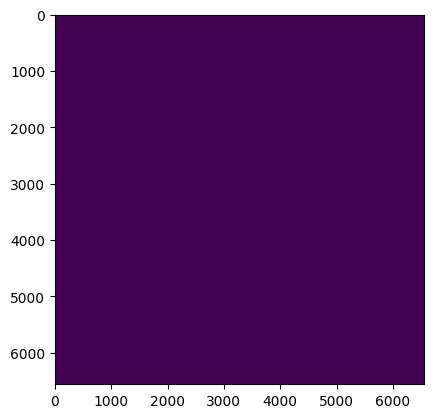

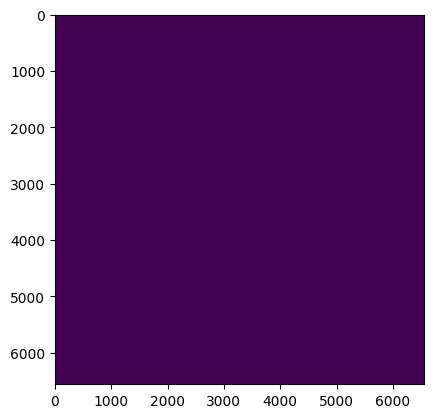

In [7]:
plt.figure()
plt.imshow(np.abs(TN_dm_sparse.toarray()))
plt.figure()
plt.imshow(np.abs(post_BSM_dm.toarray()))

Applying amplitude damping using quantum trajectory theory.

In [ ]:
kraus_ops = _build_amp_damping_kraus_operators(loss_rate = 0.5, N = N)

print(type(kraus_ops[0].todense()))

kraus_MPOs = []
trajectory_probs = []
trajectories = []

# We can do this outside of the main loop only because we know deterministically what the input state is. 
# In general, we would have to do this for all possible trajectories the system may have taken before this step. 
# You'll have to use caching (while performing this in the main loop) to make it less redundant.
for kraus_op in kraus_ops:
    kraus_MPO = create_MPO(site1 = 2, site2 = 3, total_sites = num_modes, op = kraus_op.todense(), N = N, tag = 'kraus')
    trajectory = tensor_network_apply_op_vec(kraus_MPO, psi, compress=True, contract = True, cutoff = error_tolerance)
    trajectory_prob = np.real(trajectory.H @ trajectory)

    kraus_MPOs.append(kraus_MPO)
    trajectory_probs.append(trajectory_prob)
    trajectories.append(trajectory)

<class 'numpy.matrix'>


Performing measurements: 

Threshold detection

In [ ]:
start = time.time()
coincidence_samples = []
# Perform Bell state measurement

num_trajectories = 50

# This is defined oustide the loop only for the first quantum channel since the input is known. For all subsequent trajectories, 
# you'll have to do within the loop. 
trajectory_sample_indices = np.random.choice(a = len(trajectories), size = num_trajectories, p = trajectory_probs)

trajectory_samples = np.array(trajectories)[trajectory_sample_indices]

for psi in trajectory_samples:

    psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, pnr = False, compress=True, contract=True)

    coincidence_Threshold = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = False, compress=True, contract=True, draw = False)

    coincidence_samples.append(coincidence_Threshold)

    # fringes = {theta:data for theta, data in zip(idler_angles, coincidence_Threshold)}
    # plot_coincidences(list(fringes.values()), list(fringes.keys()), signal_angles)

    print(time.time()-start)

5.074523448944092
9.140373468399048
13.673104286193848
17.182756185531616
21.22947883605957
25.042219161987305
28.793426036834717
32.73578691482544
36.5360369682312
41.49467158317566
45.28789973258972
49.2663037776947
53.7201623916626
57.42109966278076
62.14651274681091
66.77037501335144
69.96956825256348
74.05131340026855
78.62959933280945
82.70172238349915
86.5104341506958
89.79463291168213
93.94770765304565
98.58828806877136
102.5592474937439
106.70515489578247
109.72738432884216
113.12955808639526
116.69096612930298
120.25198888778687
123.88867473602295
128.2658667564392
132.28489780426025
135.4717288017273
138.58801364898682
142.48710989952087
145.04420590400696
148.39011359214783
152.21138405799866
155.3375210762024
159.0352075099945
163.18243074417114
165.82171201705933
168.21787977218628
171.3055522441864
175.84025406837463
178.89071488380432
181.43902230262756
183.30786561965942
184.81688523292542


[5.65762971e-05 1.07724384e-04 2.50947534e-04 4.58837498e-04
 6.95161900e-04 9.24787541e-04 1.12139453e-03 1.27054731e-03
 1.36810384e-03 1.41565161e-03 1.41556302e-03 1.36787199e-03
 1.27026120e-03 1.12114364e-03 9.24646451e-04 6.95161313e-04
 4.58983645e-04 2.51200588e-04 1.08012413e-04 5.68033353e-05]


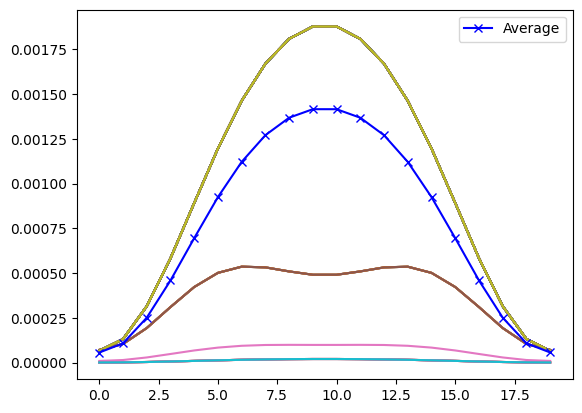

In [ ]:
# print(coincidence_samples[0][0])
# print(np.array(coincidence_samples).shape)
 
average_trajectories = np.mean(coincidence_samples, axis = 0)[0]
print(average_trajectories)

for i, coincidence_Threshold in enumerate(coincidence_samples):
    # print(coincidence_Threshold[0])
    plt.plot(coincidence_Threshold[0])

plt.plot(average_trajectories, 'b-x', label = 'Average')
plt.legend()

In [ ]:
weird_trajectory_indices = []
for i, coincidence_Threshold in enumerate(coincidence_samples):
    if coincidence_Threshold[0][10] < 0.00075 and coincidence_Threshold[0][10] > 0.00025:
        weird_trajectory_indices.append(i)

print("weird trajectories", weird_trajectory_indices)
print("weird Kraus index", trajectory_sample_indices[weird_trajectory_indices])


## recreating the Kraus ops to see which config gave us the wierd result:
# for k in range(N**2):
k = trajectory_sample_indices[weird_trajectory_indices[0]]
k1 = np.floor(k/N)
k2 = k % N
for n in range(0,N**2):

    n1 = np.floor(n/N)
    n2 = n % N

    if not ((n1>=k1) and (n2>=k2)):
        continue

    m = int((n1-k1)*N + (n2-k2))
    print("k:", k, "k1:", k1, "k2:", k2, "n1:", n1, "n2:", n2, "n:", n)
    # op_subsystem += sqrt(binom(n1, k1) * binom(n2, k2)) * np.sqrt(1-loss_rate)**(n1+n2-k1-k2) * (-1j*np.sqrt(loss_rate))**(k1+k2) * basis[:,m]*basis[:,n].transpose()                

print("Trajectory sample indices:")
print(trajectory_sample_indices)

# print("trajectory_probs")
for i, prob in enumerate(trajectory_probs):
    print(i, prob)

# V.append(sp.csr_matrix(op_subsystem))

weird trajectories [2, 6, 15, 17, 31, 35]
weird Kraus index [4 4 4 4 4 4]
k: 4 k1: 1.0 k2: 0 n1: 1.0 n2: 0 n: 4
k: 4 k1: 1.0 k2: 0 n1: 1.0 n2: 1 n: 5
k: 4 k1: 1.0 k2: 0 n1: 1.0 n2: 2 n: 6
k: 4 k1: 1.0 k2: 0 n1: 1.0 n2: 3 n: 7
k: 4 k1: 1.0 k2: 0 n1: 2.0 n2: 0 n: 8
k: 4 k1: 1.0 k2: 0 n1: 2.0 n2: 1 n: 9
k: 4 k1: 1.0 k2: 0 n1: 2.0 n2: 2 n: 10
k: 4 k1: 1.0 k2: 0 n1: 2.0 n2: 3 n: 11
k: 4 k1: 1.0 k2: 0 n1: 3.0 n2: 0 n: 12
k: 4 k1: 1.0 k2: 0 n1: 3.0 n2: 1 n: 13
k: 4 k1: 1.0 k2: 0 n1: 3.0 n2: 2 n: 14
k: 4 k1: 1.0 k2: 0 n1: 3.0 n2: 3 n: 15
Trajectory sample indices:
[0 0 4 1 0 0 4 0 0 0 0 0 0 0 0 4 8 4 0 0 0 1 0 0 0 0 1 0 0 0 0 4 0 0 0 4 1
 1 0 0 0 0 0 0 0 0 1 0 0 1]
0 0.775339397402294
1 0.09284756828051577
2 0.011138074283816008
3 0.0012085467876192487
4 0.09284756828051548
5 0.011118577186310685
6 0.001333794098487537
7 0.0001447245306502259
8 0.011138074283815979
9 0.001333794098487541
10 0.00016000308918577425
11 1.7361279384318583e-05
12 0.00120854678761925
13 0.00014472453065022647
14 1.7

[ 3 21 26 36 37 46 49]
[ 2  6 15 17 31 35]


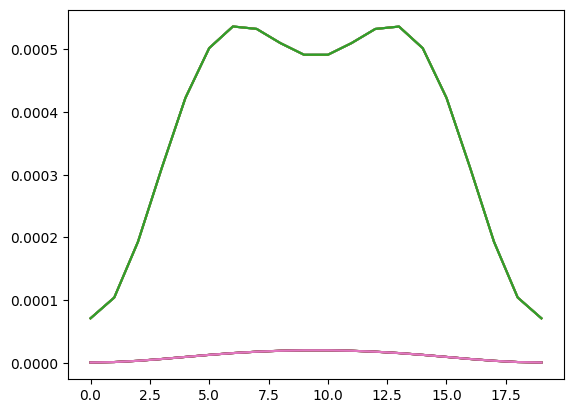

In [ ]:
## plotting the trajectories where we have just one photon loss:
trajectories_with_1 = np.where(trajectory_sample_indices == 1)[0]
print(trajectories_with_1)
for i in trajectories_with_1:
    plt.plot(coincidence_samples[i][0])

trajectories_with_4 = np.where(trajectory_sample_indices == 4)[0]
print(trajectories_with_4)
for i in trajectories_with_4:
    plt.plot(coincidence_samples[i][0])

In [ ]:
from scipy.special import binom
binom(4,0)

1.0

Common parameters and functions

In [ ]:
# params
trunc = 2
N = trunc+1
error_tolerance = 1e-15

mean_photon_num = (0.5)
efficiency = 0.9


num_modes = 8
# Create vacuum state
vacuum = create_vacuum_state(num_modes=num_modes, N=N)

# Entangled state from EPS
psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
# trying new ls here:
# psi = new_ls(N, mean_photon_num, error_tolerance) 

# Include emission from other lightsource
psi = extend_MPS(psi)

# only for drawing the TN. Not used otherwise
fix = {(f"L{j}",f"I{num_modes - i-1}"):(3*j,i+5) for j in range(10) for i in range(10)}

idler_angles = np.linspace(0, np.pi, 1)
signal_angles = np.linspace(0, 2*np.pi, 20)

Applying amplitude damping using quantum trajectory theory.

In [ ]:
kraus_ops = _build_amp_damping_kraus_operators(loss_rate = 0.5, N = N)

print(type(kraus_ops[0].todense()))

kraus_MPOs = []
trajectory_probs = []
trajectories = []

# We can do this outside of the main loop only because we know deterministically what the input state is. 
# In general, we would have to do this for all possible trajectories the system may have taken before this step. 
# You'll have to use caching (while performing this in the main loop) to make it less redundant.
for kraus_op in kraus_ops:
    kraus_MPO = create_MPO(site1 = 2, site2 = 3, total_sites = num_modes, op = kraus_op.todense(), N = N, tag = 'kraus')
    trajectory = tensor_network_apply_op_vec(kraus_MPO, psi, compress=True, contract = True, cutoff = error_tolerance)
    trajectory_prob = np.real(trajectory.H @ trajectory)

    kraus_MPOs.append(kraus_MPO)
    trajectory_probs.append(trajectory_prob)
    trajectories.append(trajectory)

<class 'numpy.matrix'>


Performing measurements: 

Threshold detection

In [ ]:
start = time.time()
coincidence_samples = []
# Perform Bell state measurement

num_trajectories = 50

# This is defined oustide the loop only for the first quantum channel since the input is known. For all subsequent trajectories, 
# you'll have to do within the loop. 
trajectory_samples = np.random.choice(a = trajectories, size = num_trajectories, p = trajectory_probs)

for psi in trajectory_samples:

    psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, pnr = False, compress=True, contract=True)

    coincidence_Threshold = rotate_and_measure(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = False, compress=True, contract=True, draw = False)

    coincidence_samples.append(coincidence_Threshold)

    # fringes = {theta:data for theta, data in zip(idler_angles, coincidence_Threshold)}
    # plot_coincidences(list(fringes.values()), list(fringes.keys()), signal_angles)

    print(time.time()-start)

1.3636505603790283
2.2408599853515625
2.9772989749908447
3.667314052581787
3.983818531036377
4.745189428329468
5.454634189605713
6.285466432571411
6.813886642456055
7.8289635181427
8.621065139770508
9.53053617477417
10.239851474761963
11.117998600006104
12.098170518875122
13.000901699066162
13.99773645401001
15.166825532913208
15.847320079803467
16.221338272094727
16.969260692596436
17.343470096588135
18.020482063293457
18.89148235321045
19.65408706665039
20.454792022705078
21.184731483459473
21.59650206565857
22.257219076156616
22.905731916427612
23.291560888290405
24.62082552909851
25.86301612854004
27.08698272705078
28.24573302268982
29.425676107406616
29.981114864349365
31.078763961791992
31.570762634277344
32.59125471115112
33.83066701889038
34.96592617034912
35.453768491744995
35.99461245536804
36.491138219833374
37.72886681556702
39.00620460510254
39.34582209587097
40.29001975059509
40.80839943885803


[4.63742820e-05 9.27719879e-05 2.24438828e-04 4.20665165e-04
 6.52518713e-04 8.89213591e-04 1.10383378e-03 1.27678398e-03
 1.39636868e-03 1.45708797e-03 1.45708797e-03 1.39636868e-03
 1.27678398e-03 1.10383378e-03 8.89213591e-04 6.52518713e-04
 4.20665165e-04 2.24438828e-04 9.27719879e-05 4.63742820e-05]


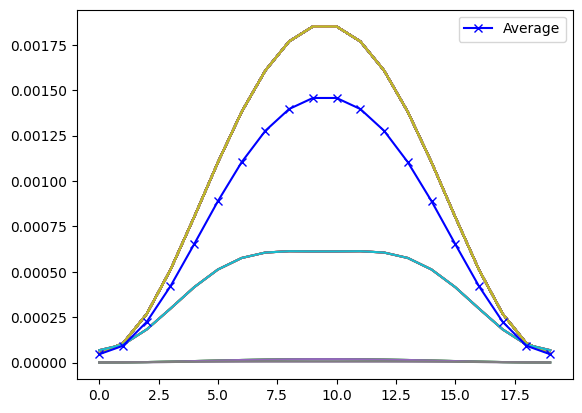

In [ ]:
# print(coincidence_samples[0][0])
# print(np.array(coincidence_samples).shape)
 
average_trajectories = np.mean(coincidence_samples, axis = 0)[0]
print(average_trajectories)

for coincidence_Threshold in coincidence_samples:
    # print(coincidence_Threshold[0])
    plt.plot(coincidence_Threshold[0])

plt.plot(average_trajectories, 'b-x', label = 'Average')
plt.legend()

NameError: name 'binom' is not defined

Threshold detection without polarization analyzers

In [ ]:
# params
trunc = 2
N = trunc+1
error_tolerance = 1e-15

mean_photon_num = (0.5)
efficiency = 0.9


num_modes = 8
# Create vacuum state
vacuum = create_vacuum_state(num_modes=num_modes, N=N)

# Entangled state from EPS
psi, TMSV_state = light_source(vacuum, N, mean_photon_num, num_modes, error_tolerance, compress=True, contract=True)
# trying new ls here:
# psi = new_ls(N, mean_photon_num, error_tolerance) 

# Include emission from other lightsource
psi = extend_MPS(psi)

# only for drawing the TN. Not used otherwise
fix = {(f"L{j}",f"I{num_modes - i-1}"):(3*j,i+5) for j in range(10) for i in range(10)}

idler_angles = np.linspace(0, np.pi, 1)
signal_angles = np.linspace(0, 4*np.pi, 40)

In [ ]:
start = time.time()
# Perform Bell state measurement
# psi = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, pnr = True, compress=True, contract=True)

coincidences = []

measurements = {1:(3,6), 0:(2,7)}
psi_1 = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, measurements, pnr = False, compress=True, contract=True)
coincidences.append(rotate_and_measure(psi_1, N, psi_1.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = False, compress=True, contract=True, draw = False))

measurements = {1:(3,7), 0:(2,6)}
psi_2 = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, measurements, pnr = False, compress=True, contract=True)
coincidences.append(rotate_and_measure(psi_2, N, psi_2.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = False, compress=True, contract=True, draw = False))

measurements = {1:(3,6,7), 0:(2,)}
psi_3 = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, measurements, pnr = False, compress=True, contract=True)
coincidences.append(rotate_and_measure(psi_3, N, psi_3.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = False, compress=True, contract=True, draw = False))

measurements = {1:(2,6), 0:(3,7)}
psi_4 = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, measurements, pnr = False, compress=True, contract=True)
coincidences.append(rotate_and_measure(psi_4, N, psi_4.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = False, compress=True, contract=True, draw = False))

measurements = {1:(2,7), 0:(3,6)}
psi_5 = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, measurements, pnr = False, compress=True, contract=True)
coincidences.append(rotate_and_measure(psi_5, N, psi_5.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = False, compress=True, contract=True, draw = False))

measurements = {1:(2,6,7), 0:(3,)}
psi_6 = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, measurements, pnr = False, compress=True, contract=True)
coincidences.append(rotate_and_measure(psi_6, N, psi_6.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = False, compress=True, contract=True, draw = False))

measurements = {1:(2,3,6), 0:(7,)}
psi_7 = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, measurements, pnr = False, compress=True, contract=True)
coincidences.append(rotate_and_measure(psi_7, N, psi_7.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = False, compress=True, contract=True, draw = False))

measurements = {1:(2,3,7), 0:(6,)}
psi_8 = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, measurements, pnr = False, compress=True, contract=True)
coincidences.append(rotate_and_measure(psi_8, N, psi_8.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = False, compress=True, contract=True, draw = False))

measurements = {1:(2,3,6,7), 0:()}
psi_9 = bell_state_measurement(psi, N, psi.site_tags, num_modes, efficiency, error_tolerance, measurements, pnr = False, compress=True, contract=True)
coincidences.append(rotate_and_measure(psi_9, N, psi_9.site_tags, num_modes, efficiency, error_tolerance, idler_angles, signal_angles, pnr = False, compress=True, contract=True, draw = False))


print(time.time()-start)

12.013540267944336


Threshold results

0.13397609044186481 [0.01027958 0.01024398 0.01017472 0.01016695 0.01032835 0.01072518
 0.01134218 0.01207392 0.01275244 0.01320173 0.0132984  0.01301534
 0.01243138 0.01170328 0.01101079 0.0104961  0.0102208  0.01015606
 0.01020853 0.01027006 0.01027006 0.01020853 0.01015606 0.0102208
 0.0104961  0.01101079 0.01170328 0.01243138 0.01301534 0.0132984
 0.01320173 0.01275244 0.01207392 0.01134218 0.01072518 0.01032835
 0.01016695 0.01017472 0.01024398 0.01027958]
0.937263737918155 [0.00013366 0.00025241 0.00059173 0.00110439 0.00172273 0.00237153
 0.00298044 0.00349265 0.00386835 0.00408369 0.00412728 0.00399702
 0.00369939 0.00325153 0.00268491 0.00204796 0.00140503 0.00083029
 0.00039683 0.00016362 0.00016362 0.00039683 0.00083029 0.00140503
 0.00204796 0.00268491 0.00325153 0.00369939 0.00399702 0.00412728
 0.00408369 0.00386835 0.00349265 0.00298044 0.00237153 0.00172273
 0.00110439 0.00059173 0.00025241 0.00013366]
0.9992294095175073 [7.65993672e-08 1.16973547e-06 5.53939655e-06 1.5

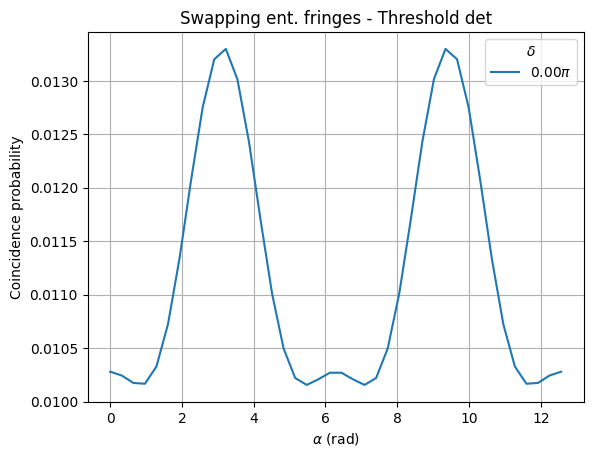

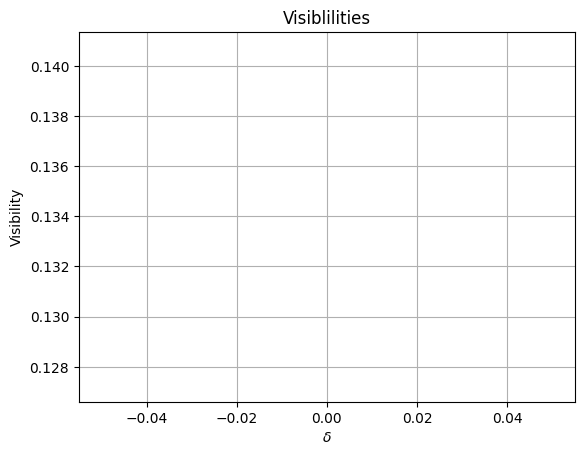

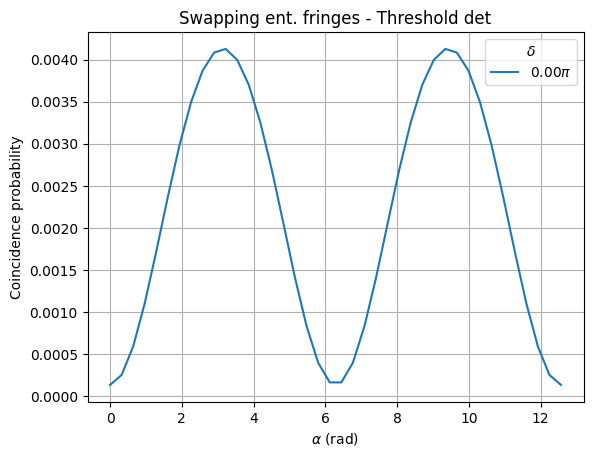

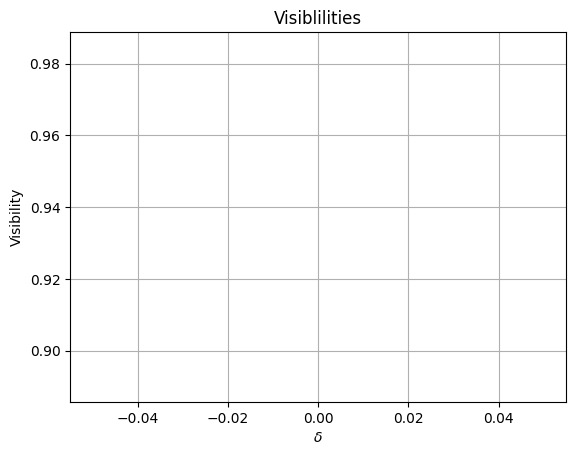

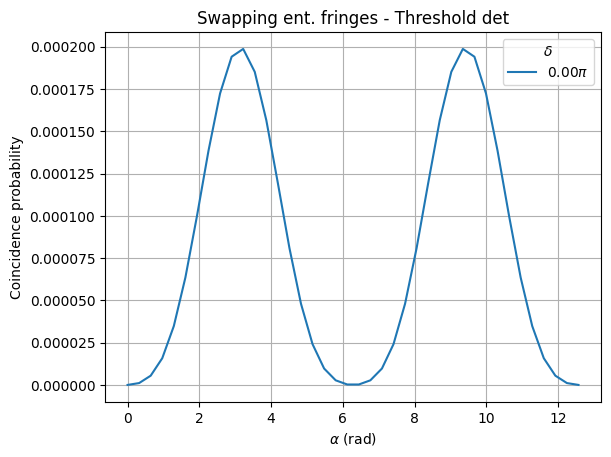

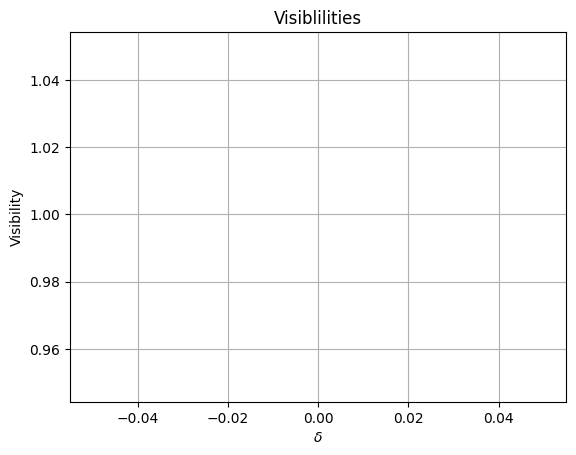

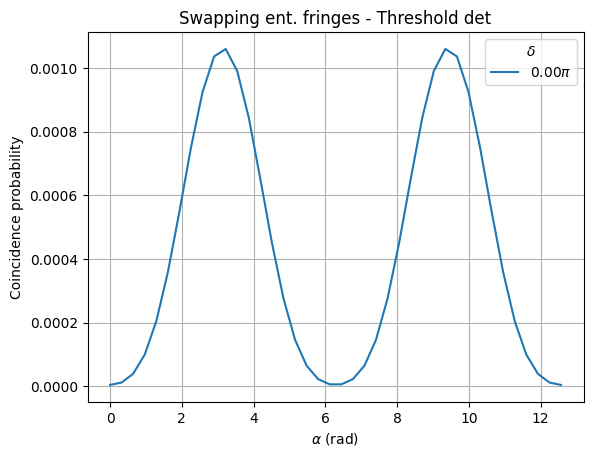

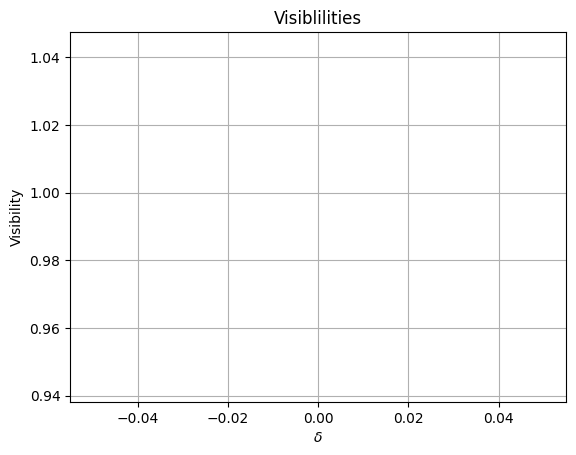

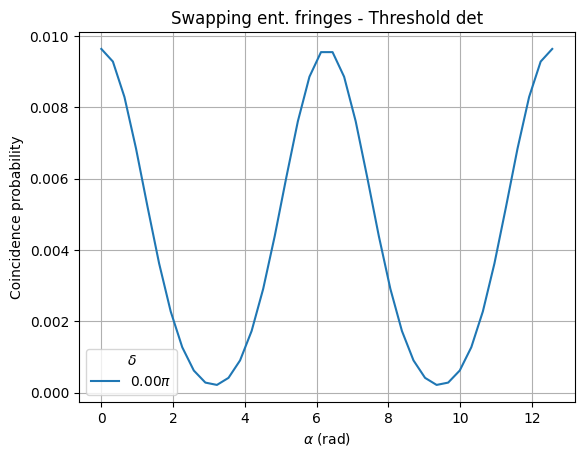

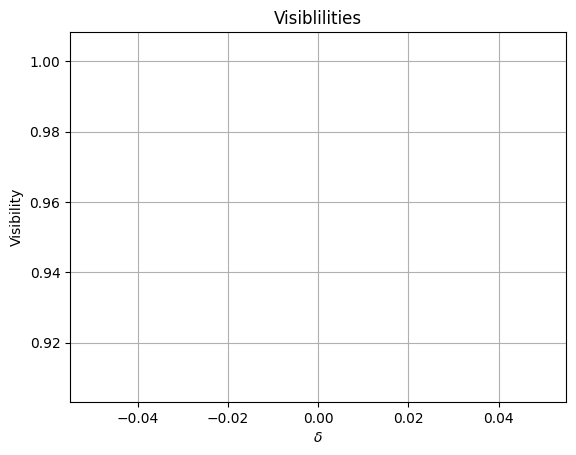

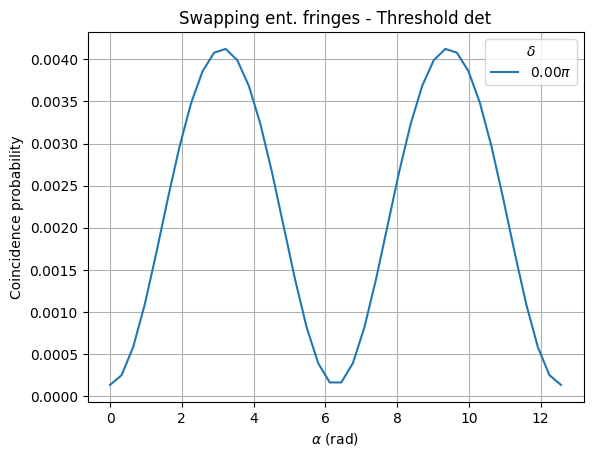

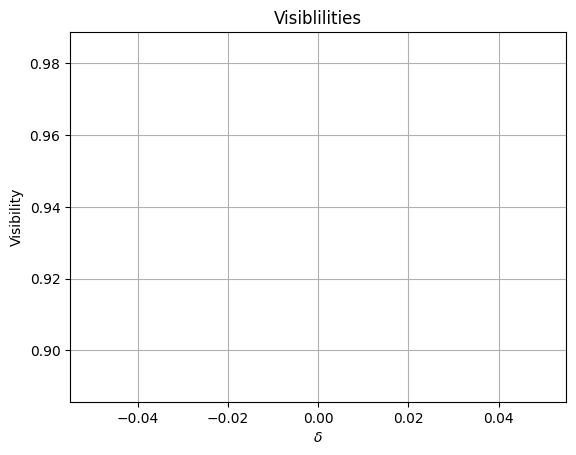

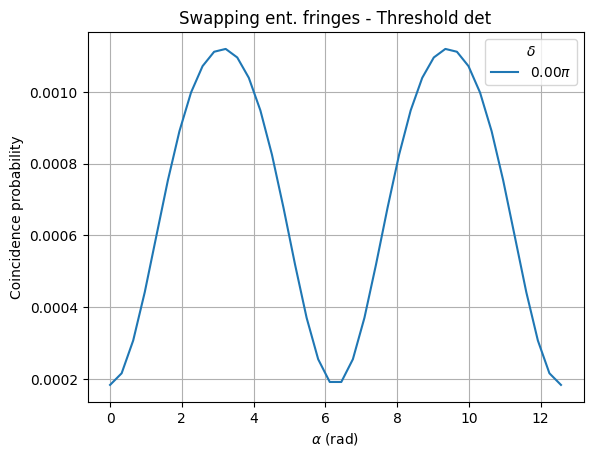

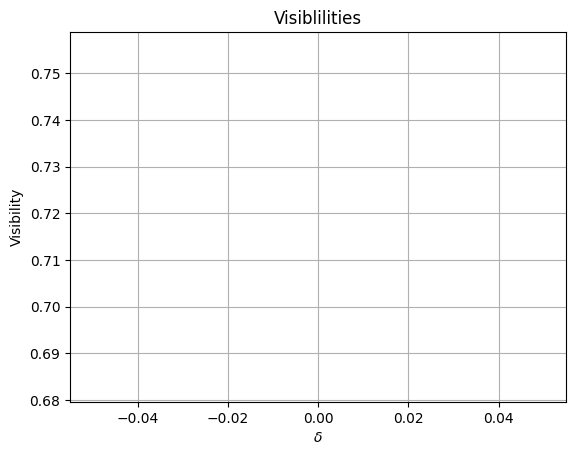

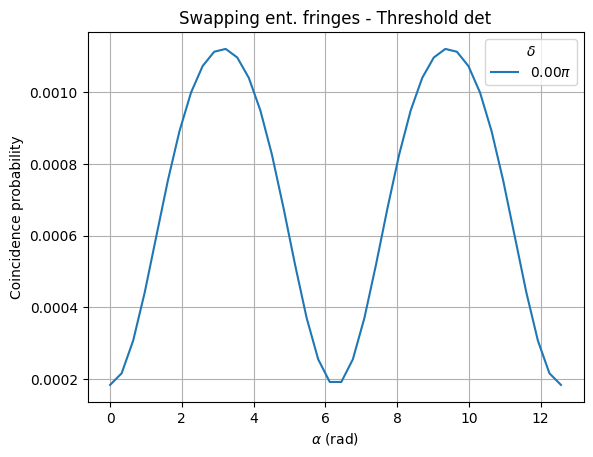

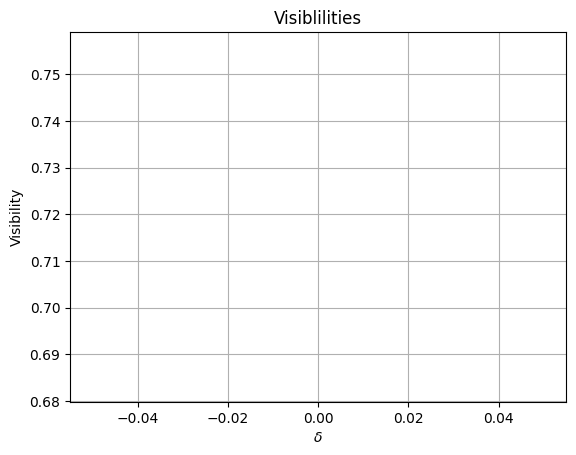

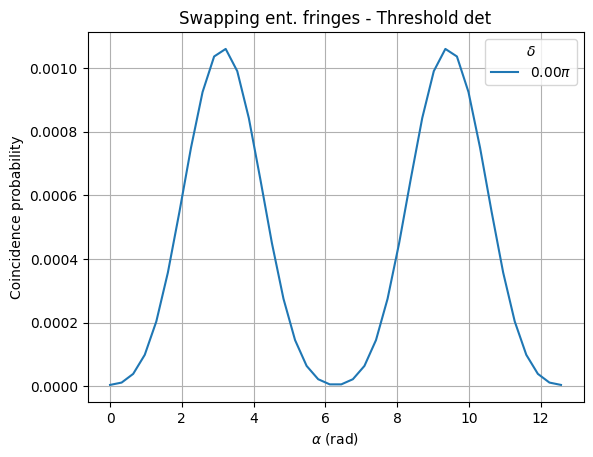

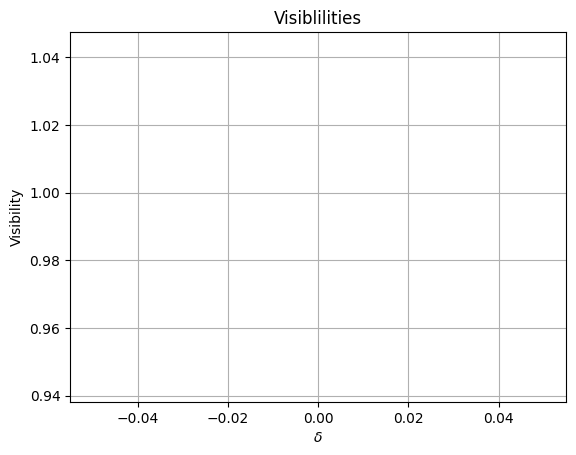

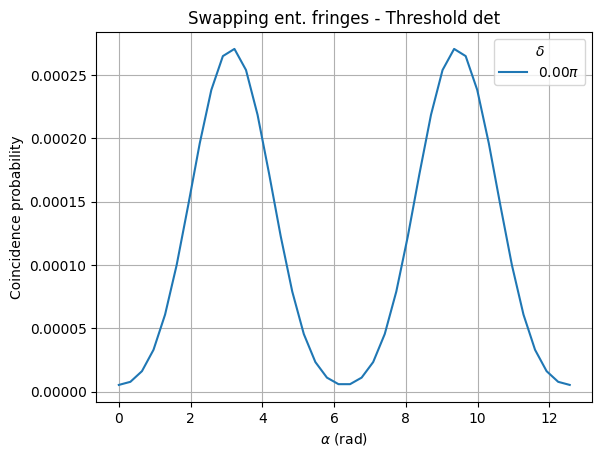

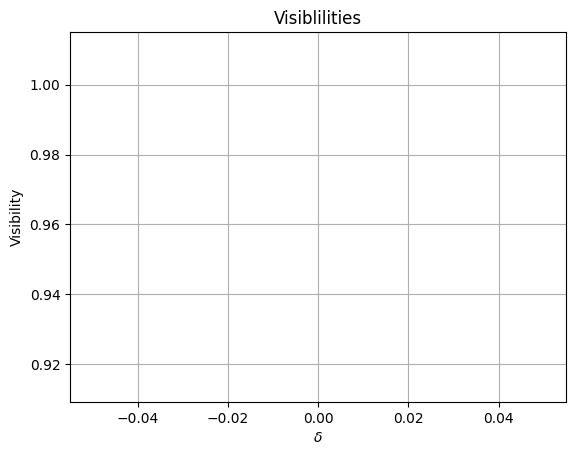

In [ ]:
# fringes = {theta:data for theta, data in zip(idler_angles, coincidence_Threshold)}
# json.dump(fringes, open(f"fringe_threshold_trunc{trunc}.json", "w"))

# plot_coincidences(coincidence_Threshold, idler_angles, signal_angles, title = "Swapping ent. fringes - Threshold det")

coincidence_total = np.sum(coincidences, axis = 0)
plot_coincidences(coincidence_total, idler_angles, signal_angles, title = "Swapping ent. fringes - Threshold det")

for coincidence in coincidences:
    plot_coincidences(coincidence, idler_angles, signal_angles, title = "Swapping ent. fringes - Threshold det")